# Task 1: Language model inference

The goal if this first task is to familiarize yourself with the huggingface transformers and dataset libraries. You will learn how to load and tokenize a dataset, how to load a pre-trained language model, and finally, how to run a model in inference mode.

Your task is to complete the missing code blocks below.

In [49]:
!pip install datasets

# import dependencies
import matplotlib.pyplot as plt
import numpy as np
import torch

from datasets import load_dataset, load_dataset_builder, get_dataset_split_names, get_dataset_config_names
from transformers import XGLMTokenizer, XGLMTokenizerFast, XGLMForCausalLM, AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from torch.utils.data import DataLoader

## Explore dataset

In [50]:
DATA_SET_NAME = "facebook/flores" # specify dataset name
MODEL_NAME = "facebook/xglm-564M" # specify model name
# MODEL_NAME = "gpt2" # specify model name

In [51]:
# Explore a dataset

# covered language codes can be found here: https://github.com/openlanguagedata/flores?tab=readme-ov-file#language-coverage

ds_builder = load_dataset_builder("facebook/flores", "deu_Latn")
print(ds_builder.info.description) # print the dataset description

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for facebook/flores contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/facebook/flores
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


The creation of FLORES-200 doubles the existing language coverage of FLORES-101. 
Given the nature of the new languages, which have less standardization and require 
more specialized professional translations, the verification process became more complex. 
This required modifications to the translation workflow. FLORES-200 has several languages 
which were not translated from English. Specifically, several languages were translated 
from Spanish, French, Russian and Modern Standard Arabic. Moreover, FLORES-200 also 
includes two script alternatives for four languages. FLORES-200 consists of translations 
from 842 distinct web articles, totaling 3001 sentences. These sentences are divided 
into three splits: dev, devtest, and test (hidden). On average, sentences are approximately 
21 words long.



In [52]:
# print the features (columns) of the dataset
# TODO: your code goes here
dataset = load_dataset("facebook/flores", "deu_Latn")
print("Columns Names:")
print(dataset.column_names)
print("\ndev Features:")
print(dataset['dev'].features)
print("\ndevtest Features:")
print(dataset['devtest'].features)

Columns Names:
{'dev': ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence'], 'devtest': ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence']}

dev Features:
{'id': Value(dtype='int32', id=None), 'URL': Value(dtype='string', id=None), 'domain': Value(dtype='string', id=None), 'topic': Value(dtype='string', id=None), 'has_image': Value(dtype='int32', id=None), 'has_hyperlink': Value(dtype='int32', id=None), 'sentence': Value(dtype='string', id=None)}

devtest Features:
{'id': Value(dtype='int32', id=None), 'URL': Value(dtype='string', id=None), 'domain': Value(dtype='string', id=None), 'topic': Value(dtype='string', id=None), 'has_image': Value(dtype='int32', id=None), 'has_hyperlink': Value(dtype='int32', id=None), 'sentence': Value(dtype='string', id=None)}


In [53]:
# get the available splits
# TODO: your code goes here
splits=get_dataset_split_names("facebook/flores", "deu_Latn")
print(splits)

['dev', 'devtest']


## Load data, tokenize, and batchify

In [54]:
# specify languages
LANGUAGES = [
    "eng_Latn",
    "spa_Latn",
    "ita_Latn",
    "deu_Latn",
    "arb_Arab",
    "tel_Telu",
    "tam_Taml",
    "quy_Latn"
]

In [55]:
# load flores data for each language
# TODO: your code goes here
flores_dataset={}
flores_dataset_builder={}
for language in LANGUAGES :
    dataset = load_dataset("facebook/flores", language)
    flores_dataset[language] = dataset
    dataset_builder = load_dataset_builder("facebook/flores", language)
    flores_dataset_builder[language] = dataset_builder

In [56]:
# let's look at the English subset
# TODO: your code goes here
eng_dataset_builder=flores_dataset_builder["eng_Latn"]
eng_dataset=flores_dataset["eng_Latn"]
print("Description:")
print(eng_dataset_builder.info.description)
print("Features:")
print(eng_dataset_builder.info.features)
print("\nSplits:")
print(eng_dataset_builder.info.splits)
print("\nColumn_names:")
print(eng_dataset.column_names)

Description:
The creation of FLORES-200 doubles the existing language coverage of FLORES-101. 
Given the nature of the new languages, which have less standardization and require 
more specialized professional translations, the verification process became more complex. 
This required modifications to the translation workflow. FLORES-200 has several languages 
which were not translated from English. Specifically, several languages were translated 
from Spanish, French, Russian and Modern Standard Arabic. Moreover, FLORES-200 also 
includes two script alternatives for four languages. FLORES-200 consists of translations 
from 842 distinct web articles, totaling 3001 sentences. These sentences are divided 
into three splits: dev, devtest, and test (hidden). On average, sentences are approximately 
21 words long.

Features:
{'id': Value(dtype='int32', id=None), 'URL': Value(dtype='string', id=None), 'domain': Value(dtype='string', id=None), 'topic': Value(dtype='string', id=None), 'has_image

In [57]:
# let's look at an individal sample from the dataset
# TODO: your code goes here
dev=eng_dataset['dev']
sample_dev = dev[0]
print(sample_dev)
sample_sentence=sample_dev['sentence']
print("\nSample Sentence:")
print(sample_sentence)

{'id': 1, 'URL': 'https://en.wikinews.org/wiki/Scientists_say_new_medical_diagnostic_chip_can_sort_cells_anywhere_with_an_inkjet', 'domain': 'wikinews', 'topic': 'health', 'has_image': 0, 'has_hyperlink': 0, 'sentence': 'On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.'}

Sample Sentence:
On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.


In [58]:
# tokenize the data

# load a pre-trained tokenizer from the huggingface hub
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# gpt2 does not have a padding token, so we have to add it manually
if MODEL_NAME == "gpt2":
    tokenizer.add_special_tokens({'pad_token': tokenizer.unk_token})

# specify the tokenization function
def tokenization(example):
    return tokenizer(example['sentence'], padding='max_length', truncation=True, max_length=42)

# TODO: your code goes here
tokenized_datasets = {}
for language, dataset in flores_dataset.items():
    tokenized_datasets[language] = dataset.map(tokenization, batched=True)

Map:   0%|          | 0/1012 [00:00<?, ? examples/s]

In [59]:
# let's take a look at a tokenized sample
# TODO: your code goes here
english_tokenized_dataset = tokenized_datasets['eng_Latn']
english_tokenized_sample = english_tokenized_dataset['dev'][0]
print("English tokenized sample")
print(english_tokenized_sample)
print("\ntokenized sample input ids:")
print(english_tokenized_sample['input_ids'])
print("\ntokenized sample attention mask")
print(english_tokenized_sample['attention_mask'])

English tokenized sample
{'id': 1, 'URL': 'https://en.wikinews.org/wiki/Scientists_say_new_medical_diagnostic_chip_can_sort_cells_anywhere_with_an_inkjet', 'domain': 'wikinews', 'topic': 'health', 'has_image': 0, 'has_hyperlink': 0, 'sentence': 'On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.', 'input_ids': [2, 1504, 28488, 4, 140003, 501, 32, 200884, 6073, 9512, 48, 88230, 76168, 32, 160597, 48, 11, 929, 55516, 35761, 155, 490, 9482, 89288, 235, 6950, 13, 11, 61368, 24049, 2005, 37295, 155, 490, 113, 213481, 72, 1117, 5885, 86368, 6929, 111288], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

tokenized sample input ids:
[2, 1504, 28488, 4, 140003, 501, 32, 200884, 6073, 9512

In [60]:
# construct a pytorch data loader for each dataset
BATCH_SIZE = 2 # for testing purposes, we start with a batch size of 2. You can change this later.

# TODO: your code goes here
for language, dataset in tokenized_datasets.items():
    for split in dataset.keys():
        dataset[split].set_format(type='torch')

data_loaders = {}
for language, dataset in tokenized_datasets.items():
    data_loaders[language] = {}
    for split in dataset.keys():
        data_loaders[language][split] = DataLoader(dataset[split], batch_size=BATCH_SIZE, shuffle=True)

english_dev_loader = data_loaders['eng_Latn']['dev']
print(english_dev_loader)

## Load model

In [61]:
# load pre-trained model from the huggingface hub
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
# put the model into evaluation mode
# TODO: your code goes here
model.eval()

XGLMForCausalLM(
  (model): XGLMModel(
    (embed_tokens): Embedding(256008, 1024, padding_idx=1)
    (embed_positions): XGLMSinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0-23): 24 x XGLMDecoderLayer(
        (self_attn): XGLMAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (activation_fn): GELUActivation()
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

XGLMForCausalLM(
  (model): XGLMModel(
    (embed_tokens): Embedding(256008, 1024, padding_idx=1)
    (embed_positions): XGLMSinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0-23): 24 x XGLMDecoderLayer(
        (self_attn): XGLMAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (activation_fn): GELUActivation()
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine

In [63]:
# Initialize a dictionary to store per-batch losses for each language
losses = {lang: {'dev': [], 'devtest': []} for lang in LANGUAGES}

# Iterate over the dataset loaders for each language
for lang, data_loader_dict in data_loaders.items():
    for split, data_loader in data_loader_dict.items():
        # Iterate over batches
        print(lang)
        print(split)
        for batch in data_loader:
            # Move input to CPU
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            # Forward pass
            with torch.no_grad():
                # Move input to GPU if available
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)

            # Compute cross-entropy loss
            loss = outputs.loss

            # Store loss
            losses[lang][split].append(loss.item())


eng_Latn
dev
eng_Latn
devtest
spa_Latn
dev
spa_Latn
devtest
ita_Latn
dev
ita_Latn
devtest
deu_Latn
dev
deu_Latn
devtest
arb_Arab
dev
arb_Arab
devtest
tel_Telu
dev
tel_Telu
devtest
tam_Taml
dev
tam_Taml
devtest
quy_Latn
dev
quy_Latn
devtest


## Visualize loss per language

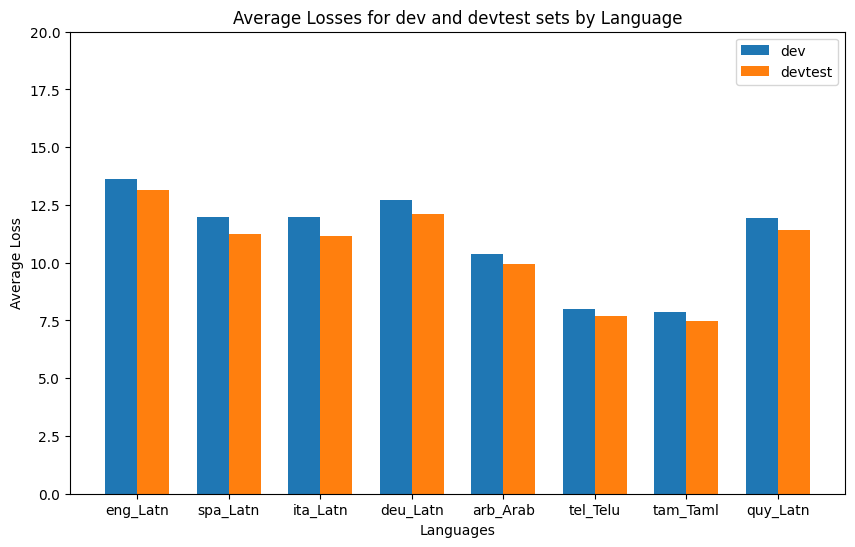

In [64]:

# create a bar plot for each langauge
# TODO: your code goes here
# Calculate the average loss for each language

average_losses = {lang: {'dev': None, 'devtest': None} for lang in LANGUAGES}

# Calculate average losses
for lang, lang_losses in losses.items():
    for split, split_losses in lang_losses.items():
        avg_loss = sum(split_losses) / len(split_losses)
        average_losses[lang][split] = avg_loss

import matplotlib.pyplot as plt

# Extracting data for plotting
languages = list(average_losses.keys())
train_avg_losses = [average_losses[lang]['dev'] for lang in languages]
validation_avg_losses = [average_losses[lang]['devtest'] for lang in languages]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define the width of each bar
bar_width = 0.35

# Set positions for the bars
index = range(len(languages))

# Plotting bars for train and validation averages
train_bars = ax.bar(index, train_avg_losses, bar_width, label='dev')
validation_bars = ax.bar([i + bar_width for i in index], validation_avg_losses, bar_width, label='devtest')

# Add labels, title, and legend
ax.set_xlabel('Languages')
ax.set_ylabel('Average Loss')
ax.set_title('Average Losses for dev and devtest sets by Language')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(languages)
ax.legend()

ax.set_ylim(0, 20)

# Show the plot
plt.show()


In [75]:
import json

# Save train losses to a JSON file
with open('dev_losses_xglm.json', 'w') as train_file:
    json.dump(losses, train_file, indent=4)

# Save validation losses to a JSON file
with open('devtest_losses_xglm.json', 'w') as validation_file:
    json.dump(losses, validation_file, indent=4)


## Comparing XGLM to GPT2

Your next task is to re-run the analysis above, but using `gpt2` as the pre-trained language model. For this exercise, focus on your native language, unless it's English or isn't covered by flores. In that case, pick another language that you can read well.

Compare the language modeling loss of XGLM and GPT2. What do you observe? Investigate the differences in tokenization for XGLM and GPT2. What do you observe? How can the good (or bad) performance of GPT2 be explained?

In [65]:
DATA_SET_NAME = "facebook/flores" # specify dataset name
# MODEL_NAME = "facebook/xglm-564M" # specify model name
MODEL_NAME = "gpt2" # specify model name

In [66]:
# tokenize the data

# load a pre-trained tokenizer from the huggingface hub
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# gpt2 does not have a padding token, so we have to add it manually
if MODEL_NAME == "gpt2":
    tokenizer.add_special_tokens({'pad_token': tokenizer.unk_token})

# specify the tokenization function
def tokenization(example):
    return tokenizer(example['sentence'], padding='max_length', truncation=True, max_length=42)

# TODO: your code goes here
tokenized_datasets = {}
for language, dataset in flores_dataset.items():
    tokenized_datasets[language] = dataset.map(tokenization, batched=True)

Map:   0%|          | 0/1012 [00:00<?, ? examples/s]

In [67]:
# construct a pytorch data loader for each dataset
BATCH_SIZE = 2 # for testing purposes, we start with a batch size of 2. You can change this later.

# TODO: your code goes here
for language, dataset in tokenized_datasets.items():
    for split in dataset.keys():
        dataset[split].set_format(type='torch')

data_loaders = {}
for language, dataset in tokenized_datasets.items():
    data_loaders[language] = {}
    for split in dataset.keys():
        data_loaders[language][split] = DataLoader(dataset[split], batch_size=BATCH_SIZE, shuffle=True)

english_dev_loader = data_loaders['eng_Latn']['dev']
print(english_dev_loader)

In [68]:
# load pre-trained model from the huggingface hub
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
# put the model into evaluation mode
# TODO: your code goes here
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [70]:
# Initialize a dictionary to store per-batch losses for each language
losses_gpt = {lang: {'dev': [], 'devtest': []} for lang in LANGUAGES}

# Iterate over the dataset loaders for each language
for lang, data_loader_dict in data_loaders.items():
    for split, data_loader in data_loader_dict.items():
        # Iterate over batches
        print(lang)
        print(split)
        for batch in data_loader:
            # Move input to CPU
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            # Forward pass
            with torch.no_grad():
                # Move input to GPU if available
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)

            # Compute cross-entropy loss
            loss = outputs.loss

            # Store loss
            losses_gpt[lang][split].append(loss.item())


eng_Latn
dev
eng_Latn
devtest
spa_Latn
dev
spa_Latn
devtest
ita_Latn
dev
ita_Latn
devtest
deu_Latn
dev
deu_Latn
devtest
arb_Arab
dev
arb_Arab
devtest
tel_Telu
dev
tel_Telu
devtest
tam_Taml
dev
tam_Taml
devtest
quy_Latn
dev
quy_Latn
devtest


In [76]:
# import json

# Save train losses to a JSON file
with open('dev_losses_gpt.json', 'w') as train_file:
    json.dump(losses_gpt, train_file, indent=4)

# Save validation losses to a JSON file
with open('devtest_losses_gpt.json', 'w') as validation_file:
    json.dump(losses_gpt, validation_file, indent=4)


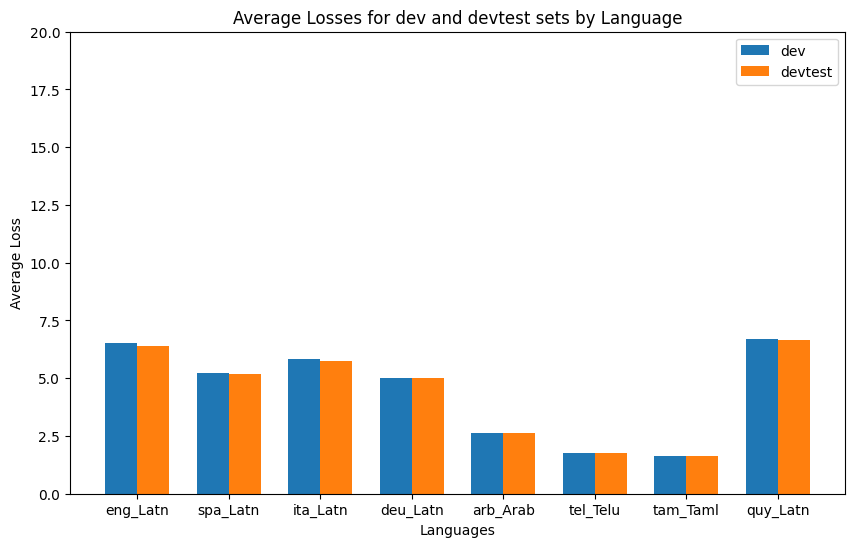

In [71]:

# create a bar plot for each langauge
# TODO: your code goes here
# Calculate the average loss for each language

average_losses_gpt = {lang: {'dev': None, 'devtest': None} for lang in LANGUAGES}

# Calculate average losses
for lang, lang_losses in losses_gpt.items():
    for split, split_losses in lang_losses.items():
        avg_loss = sum(split_losses) / len(split_losses)
        average_losses_gpt[lang][split] = avg_loss

import matplotlib.pyplot as plt

# Extracting data for plotting
languages = list(average_losses_gpt.keys())
train_avg_losses_gpt = [average_losses_gpt[lang]['dev'] for lang in languages]
validation_avg_losses_gpt = [average_losses_gpt[lang]['devtest'] for lang in languages]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define the width of each bar
bar_width = 0.35

# Set positions for the bars
index = range(len(languages))

# Plotting bars for train and validation averages
train_bars = ax.bar(index, train_avg_losses_gpt, bar_width, label='dev')
validation_bars = ax.bar([i + bar_width for i in index], validation_avg_losses_gpt, bar_width, label='devtest')

# Add labels, title, and legend
ax.set_xlabel('Languages')
ax.set_ylabel('Average Loss')
ax.set_title('Average Losses for dev and devtest sets by Language')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(languages)
ax.legend()

ax.set_ylim(0, 20)

# Show the plot
plt.show()


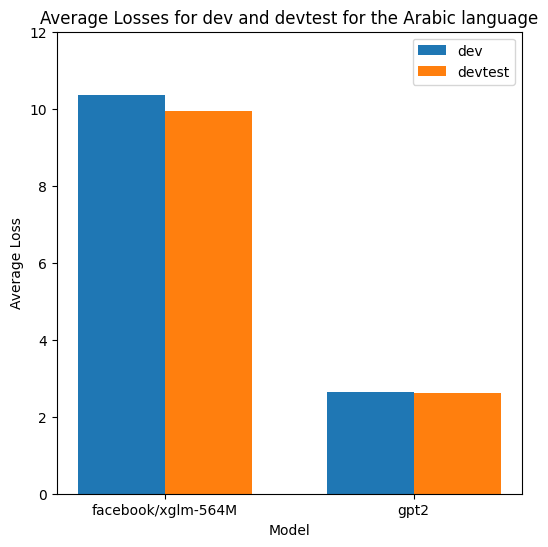

In [74]:
# Extracting data for plotting
native_lang = 'arb_Arab'
dev_avgLoss_nativeLang = average_losses[native_lang]['dev']
devtest_avgLoss_nativeLang = average_losses[native_lang]['devtest']
dev_avgLoss_nativeLang_gpt = average_losses_gpt[native_lang]['dev']
devtest_avgLoss_nativeLang_gpt = average_losses_gpt[native_lang]['devtest']

dev_nativeLang = [average_losses[native_lang]['dev'], average_losses_gpt[native_lang]['dev']]
devtest_nativeLang = [average_losses[native_lang]['devtest'], average_losses_gpt[native_lang]['devtest']]

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(6, 6))

# Define the width of each bar
bar_width = 0.35

model_names = ["facebook/xglm-564M", "gpt2"]

# Set positions for the bars
index = range(len(model_names))

# Plotting bars for train and validation averages
train_bars = ax.bar(index, dev_nativeLang, bar_width, label='dev')
validation_bars = ax.bar([i + bar_width for i in index], devtest_nativeLang, bar_width, label='devtest')

# Add labels, title, and legend
ax.set_xlabel('Model')
ax.set_ylabel('Average Loss')
ax.set_title('Average Losses for dev and devtest for the Arabic language')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(model_names)
ax.legend()

ax.set_ylim(0, 12)

# Show the plot
plt.show()
